## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python necesarios

In [41]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

Configuración del controlador e inicio de sesion Spark

In [7]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [8]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at C:\Users\estudiante\AppData\Local\Temp\ipykernel_16932\1218200805.py:5 

In [9]:
db_connection_string = 'jdbc:mysql://157.253.236.120:8080/RaSaTransaccional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_71_202415'
db_psswd = 'Estudiante_202422629'

PATH='./'

## Perfilamiento de los datos

### Conexión a fuente de datos y acceso a los datos

In [10]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos

In [11]:
sql_Tbeneficios = 'RaSaTransaccional.FuenteTiposBeneficio_Copia_E'

In [12]:
#Se cargan los dataframes desde la base de datos
Tbeneficios = obtener_dataframe_de_bd(db_connection_string, sql_Tbeneficios, db_user, db_psswd)

### Entendimiento general de datos

In [51]:
Tbeneficios.show(5)

+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|IdTipoBeneficio_T|              Nombre|     UnidadDelLimite|EsEHB|EstaCubiertaPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Fecha|
+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|              565|Nutritional Couns...|                    |   No|                  Yes|                     No|                                      No|                                    Yes| 2017|
|              795|Rehabilitative Sp...|Days per Benefit ...|  Yes|                  Yes|                    Yes|                                      No|                                    Yes| 2

In [20]:
Tbeneficios.schema

StructType(List(StructField(IdTipoBeneficio_T,IntegerType,true),StructField(Nombre,StringType,true),StructField(UnidadDelLimite,StringType,true),StructField(EsEHB,StringType,true),StructField(EstaCubiertaPorSeguro,StringType,true),StructField(TieneLimiteCuantitativo,StringType,true),StructField(ExcluidoDelDesembolsoMaximoDentroDeLaRed,StringType,true),StructField(ExcluidoDelDesembolsoMaximoFueraDeLaRed,StringType,true),StructField(Fecha,IntegerType,true)))

En esta tabla se encuentra informacion escencial del cliente en cuanto a tipos de beneficio se refiere, donde encontramos informacion acerca del nombre id tipo beneficio, si se encuetra cubierta por seguros o no, si tiene limitaciones cantitativas ademas de exclusiones dentro y fuera de la red ademas del año en un formato YYYY

**IdTipoBeneficio_T**= identificacion del tipo de beneficio

**Nombre**= nombre del cliente del beneficio

**UnidadDelLimite**= cada registro representa el límite o la frecuencia con la que se puede acceder a un beneficio en un período de tiempo dado o bajo ciertas condiciones.

**EsEHB**= del inglés "EssentialHealthBenefits" si el beneficio es obligatorio por el estado o si es un beneficio esencial

**EstaCubiertaPorSeguro**= si en ese año el beneficio era obligatorio o no por el estado

**TieneLimiteCuantitativo**=

**ExcluidoDelDesembolsoMaximoDentroDeLaRed**=

**ExcluidoDelDesembolsoMaximoFueraDeLaRed**=

**Fecha**=

In [21]:
print((Tbeneficios.count(), len(Tbeneficios.columns)))

(849, 9)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 849 tipos de beneficio y tenemos en total 9 variables a revisar de las cuales 2 son nùmericas y las demás son cadenas de caracteres.

## Estadísticas descriptivas por columna

In [26]:
# Verificar duplicados en 'IdTipoBeneficio_T'
duplicados_id = (
    Tbeneficios.groupBy("IdTipoBeneficio_T")
    .count()
    .filter(col("count") > 1)
)

# Verificar duplicados en 'Nombre'
duplicados_nombre = (
    Tbeneficios.groupBy("Nombre")
    .count()
    .filter(col("count") > 1)
)

# Verificar duplicados en 'Nombre'
duplicados_unidadDelLimite = (
    Tbeneficios.groupBy("UnidadDelLimite")
    .count()
    .filter(col("count") > 1)
)

# Mostrar resultados
print("Duplicados en IdTipoBeneficio_T:")
duplicados_id.show()

print("\nDuplicados en Nombre:")
duplicados_nombre.show()

print("\nDuplicados en UnidadDelLimite:")
duplicados_unidadDelLimite.show()

Duplicados en IdTipoBeneficio_T:
+-----------------+-----+
|IdTipoBeneficio_T|count|
+-----------------+-----+
|              540|    5|
|               85|   13|
|              580|    2|
|               65|    2|
|              255|    3|
|              970|    3|
|              375|    2|
|              115|    2|
|              830|   19|
|             1030|   14|
|              460|    4|
|              350|   11|
|              860|    2|
|              875|    2|
|              330|   14|
|              625|    5|
|              190|   29|
|              225|    2|
|              360|    9|
|              725|    8|
+-----------------+-----+
only showing top 20 rows


Duplicados en Nombre:
+--------------------+-----+
|              Nombre|count|
+--------------------+-----+
|Eye Refractive Su...|    2|
| Orthodontia - Adult|    6|
|Prenatal and Post...|    2|
|Human Leukocyte A...|    2|
|Outpatient Observ...|    2|
|Primary Care Visi...|    2|
|Post-cochlear imp...|    2|
|Fam

Se identica apoyado con **SQL workbench** que los id repetidos corresponden a un unico tipo de beneficio lo cual es un problema de unicidad, consistencia y validez de datos que se abordara mas adelante.

Algunos de los hallazgos encontrados en estas tablas son:

1. el id del '190'que corresponde al beneficio 'Dental Check-Up for Children' es el servicio mas usado '29'
2. UnidadDelLimite que mas frecuente Visit(s) per Year


+--------------------+---+---+
|              Column|Yes| No|
+--------------------+---+---+
|               EsEHB|430|399|
|EstaCubiertaPorSe...|743| 98|
|TieneLimiteCuanti...|271|542|
|ExcluidoDelDesemb...| 60|787|
|ExcluidoDelDesemb...|333|516|
+--------------------+---+---+



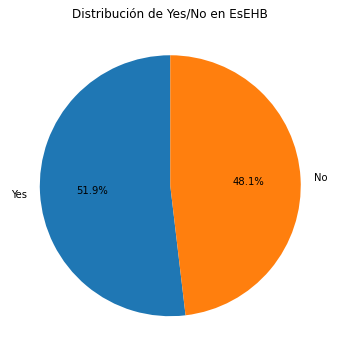

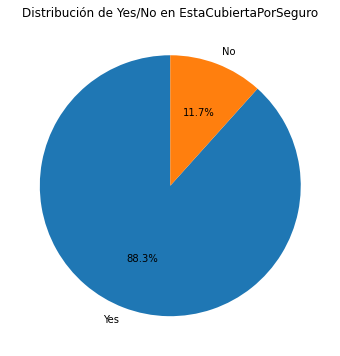

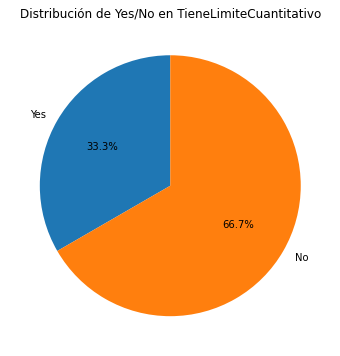

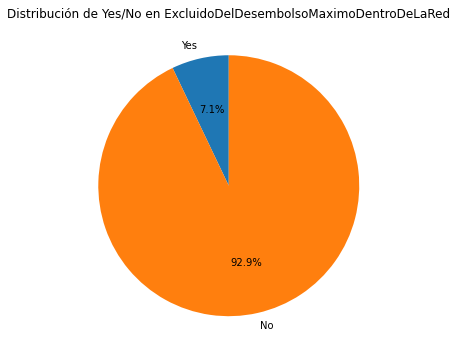

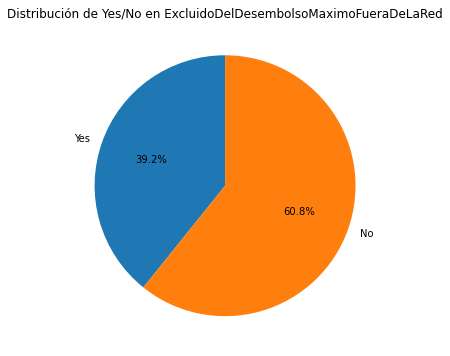

In [18]:
%matplotlib inline
columns_to_count = [
    "EsEHB", 
    "EstaCubiertaPorSeguro", 
    "TieneLimiteCuantitativo", 
    "ExcluidoDelDesembolsoMaximoDentroDeLaRed", 
    "ExcluidoDelDesembolsoMaximoFueraDeLaRed"
]

# Crear un DataFrame con las cuentas de "Yes" y "No" por cada columna
yes_no_counts = []

for col_name in columns_to_count:
    yes_count = Tbeneficios.filter(col(col_name) == "Yes").count()
    no_count = Tbeneficios.filter(col(col_name) == "No").count()
    yes_no_counts.append((col_name, yes_count, no_count))

# Convertir a un DataFrame con las columnas especificadas
yes_no_df = spark.createDataFrame(yes_no_counts, ["Column", "Yes", "No"])

# Mostrar el resultado
yes_no_df.show()

yes_no_df = pd.DataFrame(yes_no_counts, columns=["Column", "Yes", "No"])
for index, row in yes_no_df.iterrows():
    plt.figure(figsize=(6, 6))
    plt.pie(
        [row["Yes"], row["No"]],
        labels=["Yes", "No"],
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title(f"Distribución de Yes/No en {row['Column']}")
    plt.show()

In [28]:
from pyspark.sql.functions import col, desc
fecha_con_mas_registros = (
    Tbeneficios.groupBy("Fecha")
    .count()
    .orderBy(desc("count"))
    .first()
)

# Muestra la fecha con más registros en formato int
print(f"La fecha con más registros es: {fecha_con_mas_registros['Fecha']} con {fecha_con_mas_registros['count']} registros.")

total_registros = Tbeneficios.count()
print(f"Total de registros en el DataFrame: {total_registros}")

La fecha con más registros es: 2017 con 672 registros.
Total de registros en el DataFrame: 849


Se encuentra que 0.79% de los registros corresponden al año 2017 

### Análisis de calidad de datos

La calidad de los datos consiste en validar la idoneidad de los datos analizando varias dimensiones, entre las cuales resaltamos:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

## UNICIDAD

Como se evidencia en las tablas generadas anteriormente no existe una buena unicidad de datos en la base de datos ya que se repite varias vaces y no se suman correatamente por errores tipograficos en los datos como por ejemplo **Visit(s) per Year** con **Visit(s) per year** lo cual evidencia una falta de limpieza en los datos en el apartado de unicidad

In [45]:
for column in Tbeneficios.columns:
    total_count = Tbeneficios.count()
    unique_count = Tbeneficios.select(column).distinct().count()
    uniqueness_percentage = (unique_count / total_count) * 100

    print(f"Columna: {column} - Valores únicos: {unique_count} - Porcentaje de unicidad: {uniqueness_percentage:.2f}%")

# Identificar duplicados en una columna específica (por ejemplo, 'ProductoID')
duplicados = Tbeneficios.groupBy("IdTipoBeneficio_T","UnidadDelLimite", "Nombre").count().filter(col("count") > 1)
duplicados_count = duplicados.count()

print(f"Número de productos duplicados: {duplicados_count}")

duplicados.show()

Columna: IdTipoBeneficio_T - Valores únicos: 178 - Porcentaje de unicidad: 20.97%
Columna: Nombre - Valores únicos: 178 - Porcentaje de unicidad: 20.97%
Columna: UnidadDelLimite - Valores únicos: 63 - Porcentaje de unicidad: 7.42%
Columna: EsEHB - Valores únicos: 3 - Porcentaje de unicidad: 0.35%
Columna: EstaCubiertaPorSeguro - Valores únicos: 3 - Porcentaje de unicidad: 0.35%
Columna: TieneLimiteCuantitativo - Valores únicos: 4 - Porcentaje de unicidad: 0.47%
Columna: ExcluidoDelDesembolsoMaximoDentroDeLaRed - Valores únicos: 3 - Porcentaje de unicidad: 0.35%
Columna: ExcluidoDelDesembolsoMaximoFueraDeLaRed - Valores únicos: 2 - Porcentaje de unicidad: 0.24%
Columna: Fecha - Valores únicos: 2 - Porcentaje de unicidad: 0.24%
Número de productos duplicados: 201
+-----------------+--------------------+--------------------+-----+
|IdTipoBeneficio_T|     UnidadDelLimite|              Nombre|count|
+-----------------+--------------------+--------------------+-----+
|              125|Days 

para las columnas de tipo binario endonde se tienen valores Yes/No se es evidente el bajo % de unicidad , mientras que para las columnas como los son **IdTipoBeneficio_T**, **UnidadDelLimite** y **Nombre** se esperarian mejores valores

## COMPLETIDUD

Contar vacios

In [40]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        # Contar valores nulos y cadenas vacías
        vacios_nulos = df.filter(df[c].isNull()).count()
        vacios_cadenas = df.filter(df[c] == '').count()
        total_vacios = vacios_nulos + vacios_cadenas
        
        if total_vacios != 0:
            print(f'Número de vacíos para la columna {c}: {total_vacios} (Nulos: {vacios_nulos}, Cadenas vacías: {vacios_cadenas})')
            resultados.append(total_vacios)
    
    return resultados


def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [42]:
columnas_vacias_Tbeneficios = contar_vacios(Tbeneficios)

Número de vacíos para la columna UnidadDelLimite: 559 (Nulos: 0, Cadenas vacías: 559)


Se evidencia que para la columna UnidadDelLimite se encuentran 559 cadenas vacias 

In [43]:
columnas_alta_cardinalidad_Tbeneficios = cardinalidad(Tbeneficios)
columnas_alta_cardinalidad_Tbeneficios

{}

In [46]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, LongType, FloatType, StringType

# Función para contar valores nulos, ceros y vacíos en cada columna
def contar_nulos_ceros_vacios(df, columnas):
    for columna in columnas:
        # Contar valores nulos
        nulos = df.filter(F.col(columna).isNull()).count()
        
        # Contar valores iguales a 0 (solo si es numérico)
        data_type = df.schema[columna].dataType
        if isinstance(data_type, (IntegerType, DoubleType, LongType, FloatType)):
            ceros = df.filter(F.col(columna) == 0).count()
        else:
            ceros = 0
        
        # Contar valores vacíos (solo si es de tipo string)
        if isinstance(data_type, StringType):
            vacios = df.filter(F.col(columna) == "").count()
        else:
            vacios = 0
        
        # Imprimir resultados
        print(f"Columna: {columna} - Nulos: {nulos}, Ceros: {ceros}, Vacíos: {vacios}")

# Lista de las columnas a verificar
columnas = Tbeneficios.columns

# Contar los valores nulos, ceros y vacíos en cada columna
contar_nulos_ceros_vacios(Tbeneficios, columnas)

Columna: IdTipoBeneficio_T - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: Nombre - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: UnidadDelLimite - Nulos: 0, Ceros: 0, Vacíos: 559
Columna: EsEHB - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: EstaCubiertaPorSeguro - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: TieneLimiteCuantitativo - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: ExcluidoDelDesembolsoMaximoDentroDeLaRed - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: ExcluidoDelDesembolsoMaximoFueraDeLaRed - Nulos: 0, Ceros: 0, Vacíos: 0
Columna: Fecha - Nulos: 0, Ceros: 0, Vacíos: 0


## validez

In [49]:
def verificar_valores(df, columnas):
    for c in columnas:
        # Filtrar y obtener los valores diferentes de 'Yes' o 'No'
        valores_invalidos = df.filter(~(col(c).isin('Yes', 'No')))
        conteo_invalidos = valores_invalidos.count()

        if conteo_invalidos > 0:
            print(f'La columna {c} tiene {conteo_invalidos} valores diferentes de "Yes" o "No":')
            # Mostrar los valores diferentes
            valores_diferentes = valores_invalidos.select(c).distinct().collect()
            for valor in valores_diferentes:
                print(f' - {valor[0]}')

# Lista de columnas a verificar
columnas_a_verificar = [
    "EsEHB",
    "EstaCubiertaPorSeguro",
    "TieneLimiteCuantitativo",
    "ExcluidoDelDesembolsoMaximoDentroDeLaRed",
    "ExcluidoDelDesembolsoMaximoFueraDeLaRed"
]

# Ejecutar la verificación
verificar_valores(Tbeneficios, columnas_a_verificar)

La columna EsEHB tiene 20 valores diferentes de "Yes" o "No":
 - True
La columna EstaCubiertaPorSeguro tiene 8 valores diferentes de "Yes" o "No":
 - False
La columna TieneLimiteCuantitativo tiene 36 valores diferentes de "Yes" o "No":
 - Nein
 - Si
La columna ExcluidoDelDesembolsoMaximoDentroDeLaRed tiene 2 valores diferentes de "Yes" o "No":
 - Algunas veces


Se evidencian algunos datos invalidos en las columnas descritas los cuales se imprimen para identificarlos y posteriormente hacer un tratamiento a estos datos

## Conclusión del entendimiento de datos 

#### Justificación de si es posible resolver los análisis basados en tableros de control propuestos

El modelo si es posible de resolver con analisis basado en tableros de control, solo si antes se hacen los ajustes a los hallazgos encontrados en la tabla ***Tipo de beneficios*** los cuales fueron descritos anteriormente 
